In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

tcmalloc: large alloc 1073750016 bytes == 0x5755a000 @  0x7fd0503ab2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
cuda:0


In [2]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gzip
import pickle
import pdb
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from IPython.core.debugger import set_trace

train_data = datasets.MNIST('/Users/Chris/Downloads',train = True, download= True, transform= torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_data = datasets.MNIST('/Users/Chris/Downloads',train = False, download= True, transform= torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

class Sign(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x.clone())
        x[x<0] = -1
        x[x>=0] = 1
        return x
    @staticmethod
    def backward(ctx, grad_output):
      x, = ctx.saved_tensors
      grad_input = grad_output.clone()
      grad_input = grad_input.to(device)
      calculate = (x.abs() < 1.)
      calculate = calculate.type(torch.FloatTensor)
      calculate = calculate.to(device)
      grad_input = calculate * grad_input
      return grad_input
sign = Sign.apply
criterion = nn.CrossEntropyLoss()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 10)
        self.act = nn.Softmax()
        self.relu = nn.ReLU()

    def forward(self, x):

        Sign()
        x = sign(self.conv1(x))
        x = sign(self.conv2(x))
        x = sign(self.conv3(x))
        x = sign(self.conv4(x))
        x = sign(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        x = sign(self.fc1(x))
        x = self.act(self.fc2(x))
        return x
        # Activation function, editable

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.15)
net.zero_grad()
trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=True)
dataiter = iter(trainloader)
i = 0
j = 0
count = 0
test_accuracy = 0
accuracy_vector = []
test_accuracy_vector = []

for j in range(0,100):
  dataiter = iter(trainloader)
  if test_accuracy > 0.95:
    break
  for batch in dataiter:
    image = batch[0]
    image = image*2 -1
    label = batch[1]
    # Transfer to GPU
    image, label = image.to(device), label.to(device)
    #print(net(local_batch))
    optimizer.zero_grad()
    output = net(image)
    #print(output.argmax(1))
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    i = i+1
    z = output.max(1)
    correct_guesses = z[1] == label
    correct_guesses = correct_guesses.type(torch.FloatTensor)
    accuracy = correct_guesses.mean()
    accuracy_vector.append(accuracy*100)
    count = count + 1
    if count == 600:
      print(test_accuracy)
      testiter = iter(testloader)
      count = 0
      for test_batch in testiter:
        test_image = test_batch[0]
        test_image = test_image*2 -1
        test_label = test_batch[1]
        test_image, test_label = test_image.to(device), test_label.to(device)
        outputtest = net(test_image)
        ztest = outputtest.max(1)
        test_correct_guesses = ztest[1] == test_label
        test_correct_guesses = test_correct_guesses.type(torch.FloatTensor)
        test_accuracy = test_correct_guesses.mean()
        test_accuracy_vector.append(test_accuracy*100)
        break

Processing...
Done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0
tensor(0.9061)
tensor(0.9393)
tensor(0.9478)


In [1]:

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign() > 0
    sign_data_grad = sign_data_grad.type(torch.cuda.FloatTensor)
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

trickloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
trickiter = iter(trickloader)
for batch in trickiter:
  image = batch[0].clone()
  image = image*2 -1
  starting_image = image.clone()
  special_label = batch[1]
  special_label = special_label.to(device)
  adversarial_optimizer = optim.SGD(net.parameters(), lr=0.10)
  image = image.to(device)
  image.requires_grad = True
  output = net(image)
  guess = output.max(1)
  guess_value = guess[1]
  false_target = torch.tensor([2])
  false_target = false_target.type(torch.cuda.LongTensor)
  loss = criterion(output, perturbed_image)
  loss.retain_grad()
  pdb.set_trace()
  while (guess_value == special_label) or (guess[0] < 0.9):
    image = image.to(device)
    image = torch.autograd.Variable(image, requires_grad = True)
    output = net(image)
    loss = criterion(output, perturbed_image)
    loss.retain_grad()
    net.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = fgsm_attack(image, 0.01, data_grad)
    output = net(perturbed_image)
    guess = output.max(1)
    guess_value = guess[1]
    image = perturbed_image
  pdb.set_trace()
  
    
    
  
    

NameError: ignored

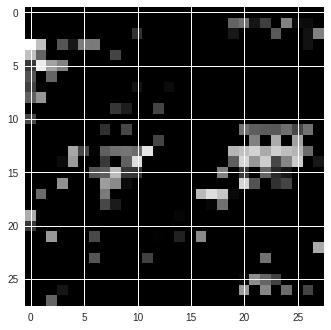

tensor([8], device='cuda:0')
tensor([1], device='cuda:0')


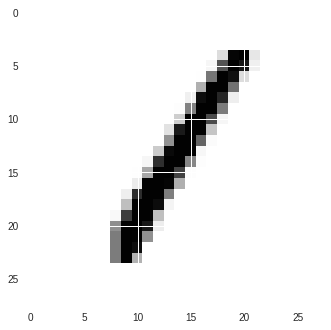

--Call--
> /usr/local/lib/python3.6/dist-packages/IPython/core/displayhook.py(236)__call__()
-> def __call__(self, result=None):


In [0]:
back_on_cpu = perturbed_image.cpu()
numImg = back_on_cpu.detach().numpy()
numImg = np.squeeze(numImg)
imgplot = plt.imshow(numImg)
plt.show()
print(guess_value)

back_on_cpu2 = starting_image.cpu()
numImg2 = back_on_cpu2.detach().numpy()
numImg2 = np.squeeze(numImg2)
imgplot2 = plt.imshow(numImg2)
print(special_label)

plt.show()
pdb.set_trace()
